In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

## Wczytanie zbioru danych
Poniższy kod przygotowuje zbiór danych do przeprowadzenia treningu. Zostały przygotowane dwa scenariusze:

- A2D2
- Cityscapes

Odpowiedni zbiór wystarczy odkomentować w celu przeprowadzenia na nim treningu.

In [2]:
from transforms import *
from utils.encoding import ClassMapper

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

# mapper = ClassMappeer(
#     dataset_class=A2D2Dataset,
#     train_transforms=transforms,
#     infer_transforms=transforms_test,
#     reduced_subset=True
#     )

# train_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='train',
#     transforms=mapper.wrap_train
    
# )

# test_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='val',
#     transforms=mapper.wrap_train
# )

# Cityscapes

mapper = ClassMapper(
    dataset_class=Cityscapes,
    train_transforms=transforms,
    infer_transforms=transforms_test,
    reduced_subset=True
    )

train_dataset = Cityscapes(
    root=cityscapes_root,
    split='train',
    target_type="semantic",
    transforms=mapper.wrap_train
)

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='val',
    target_type="semantic",
    transforms=mapper.wrap_train
)

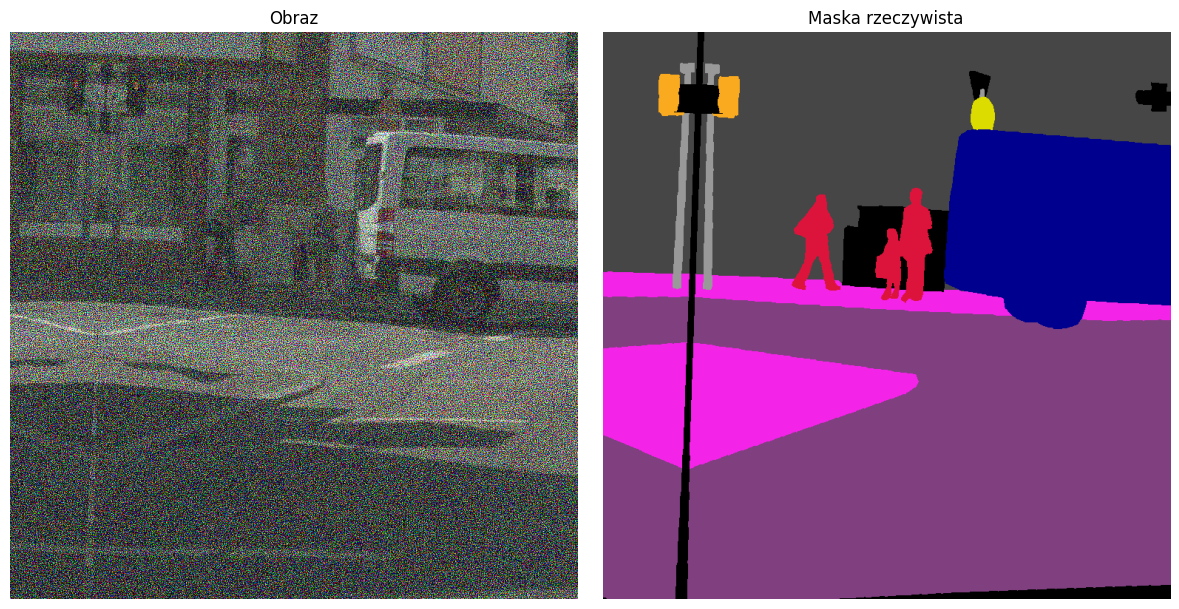

In [3]:
from utils.image import *

image, mask = test_dataset[5]

display_image_and_mask(image=image, mask_true=mask, mapper=mapper)

In [4]:
# Wyświetlanie widocznych na obrazie masek

classes = np.unique(mask)
names = {
    f'{mapper.mapping[int(cid)][1]}'
    for cid in classes
    if int(cid) in mapper.mapping
}
print("\n".join(names))

building
sidewalk
car
road
unlabeled
traffic sign
pole
traffic light
person


In [5]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True,
    drop_last=True
)

## Trening
Poniższy skrypt inicjalizuje model oraz rozpoczyna jego trening przy zadanych wartościach hiperparametrów.

In [ ]:
import os
import segmentation_models_pytorch as smp

from training.setup_training import *

# backbones = [
#     smp.DeepLabV3, smp.DeepLabV3Plus, smp.Linknet, smp.Segformer, smp.Unet, 
#     smp.UnetPlusPlus, smp.FPN, smp.PAN, smp.UPerNet, smp.MAnet, smp.PSPNet
# ]

# backbones = [
#     smp.Unet, smp.DeepLabV3Plus, smp.Segformer, smp.PAN
#     ]

backbones = [
    smp.DeepLabV3Plus
    ]

# encoders = [
#     'resnet50', 'resnext50_32x4d', 'se_resnext50_32x4d', 'efficientnet-b4', 'mit_b1', 'mobileone_s4', 'resnext101_32x8d'
# ]

encoders = [
    'se_resnext50_32x4d'
]

for backbone in backbones:
    for encoder in encoders:
        setup_training(
            train_loader=train_loader,
            val_loader=test_loader,
            mapper=mapper,
            backbone=backbone,
            encoder=encoder,
            weights='imagenet'
        )


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 7.289851944016175e-05
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_c71e37fe-6837-4ca3-8633-3c2f902aa6a3.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_c71e37fe-6837-4ca3-8633-3c2f902aa6a3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | model      | DeepLabV3Plus | 16.1 M | train
1 | dice_loss  | DiceLoss      | 0      | train
2 | focal_loss | FocalLoss     | 0      | train
-----------------------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.294    Total estimated model params size (MB)
533       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Średnia latencja : 110.823 ms  |  FPS : 9.0 | Alloc: 437.9 MiB | Reserved: 1771.8 MiB | Peak: 1258.3 MiB


## Przykłady interferencji
Poniższy kod prezentuje przykłady interferencji.
- Interferencja na `test_dataset` z wyświetlaniem maski rzeczywistej.
- Interferencja na pojedyńczym obrazie ze zbioru testowego.
- Interferencja na własnym obrazie.

In [7]:
import glob, os

def find_checkpoints(logs_root):
    checkpoint_files = {}
    logs = glob.glob(os.path.join(logs_root, '*'))
    for log in logs:
        versions = glob.glob(os.path.join(log, 'version_*'))
        for version_pth in versions:
            version = version_pth.split('_')[1]
            checkpoints = glob.glob(os.path.join(version_pth, 'checkpoints', '*.ckpt'))
            for checkpoint in checkpoints:
                checkpoint_files.update({checkpoint: [version]})
    return checkpoint_files

find_checkpoints('.\\logs')

{'.\\logs\\DeepLabV3Plus\\version_1\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['1'],
 '.\\logs\\DeepLabV3Plus\\version_2\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['2'],
 '.\\logs\\DeepLabV3Plus\\version_3\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['3'],
 '.\\logs\\DeepLabV3Plus\\version_4\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['4'],
 '.\\logs\\DeepLabV3Plus\\version_5\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['5'],
 '.\\logs\\DeepLabV3Plus\\version_6\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['6'],
 '.\\logs\\DeepLabV3Plus\\version_8\\checkpoints\\epoch=49-step=37150_fixed.ckpt': ['8'],
 '.\\logs\\DeepLabV3Plus\\version_9\\checkpoints\\epoch=1-step=1486.ckpt': ['9']}

In [8]:
import torch
from utils.image import *
from training.model import ExperimentalModel


import segmentation_models_pytorch as smp

# Załadowanie modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ExperimentalModel.load_from_checkpoint(
    model_arch=smp.DeepLabV3Plus,
    checkpoint_path=".\\logs\\DeepLabV3Plus\\version_2\\checkpoints\\epoch=49-step=37150_fixed.ckpt",
    weights="imagenet",
    encoder="resnext50_32x4d",
    in_channels=3,
    mapper=mapper
)

model = model.to(device)

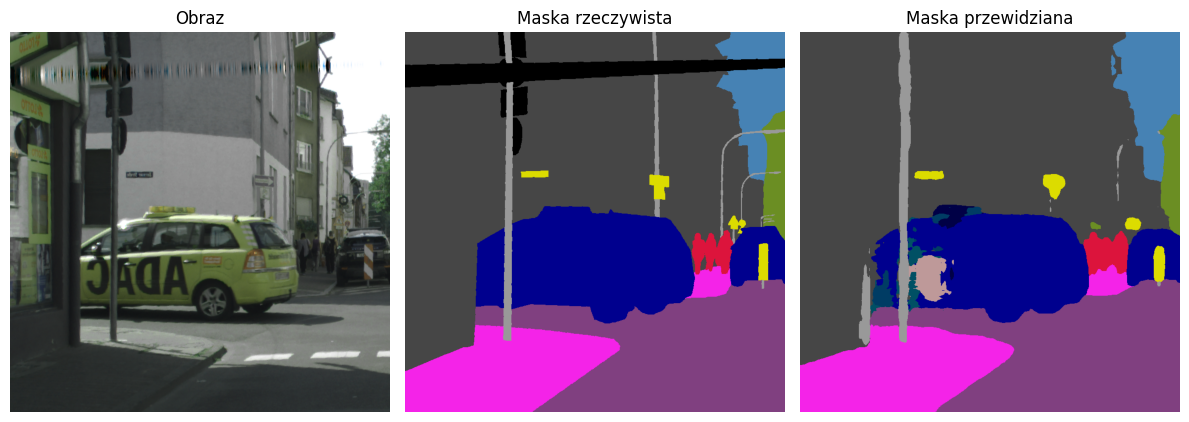

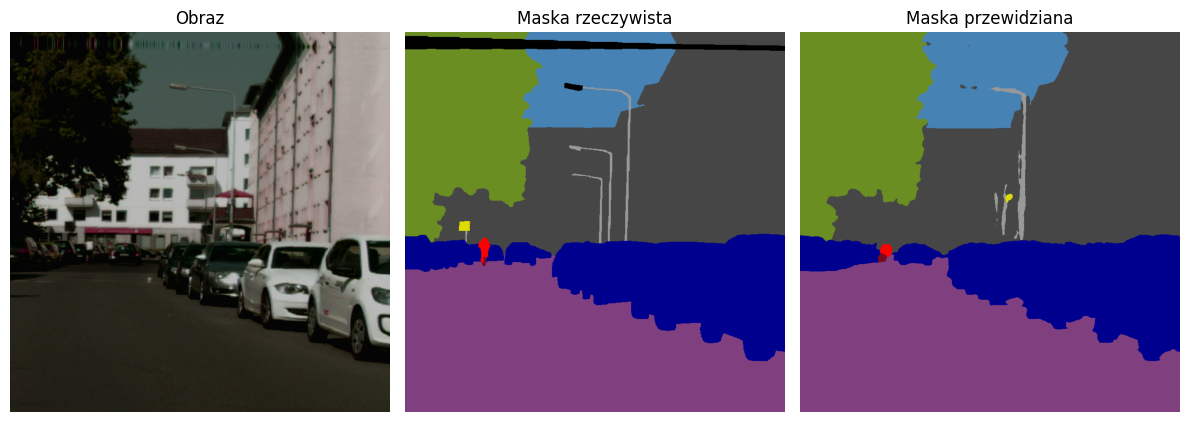

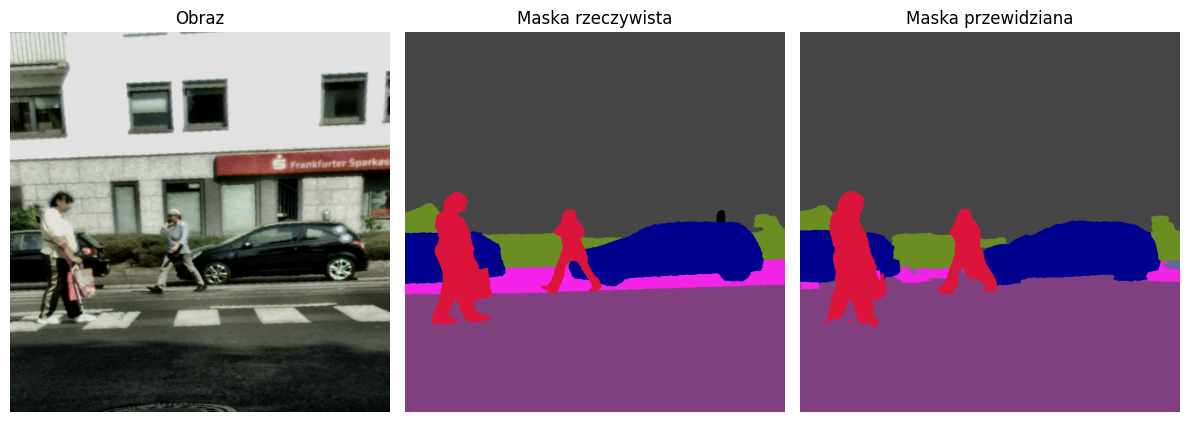

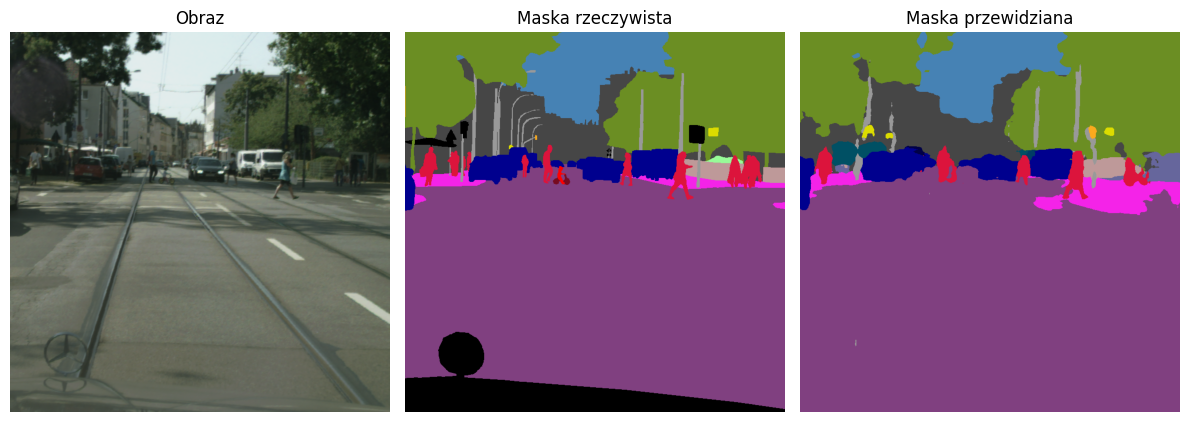

In [9]:
import torch
from utils.image import *

# Cały zbiór walidacyjny

images, masks = next(iter(test_loader))
images = images.to(device)
masks  = masks.to(device)

masks = masks.squeeze(1)

with torch.inference_mode():
    model.eval()
    logits = model(images)

pr_masks = logits.softmax(dim=1).argmax(dim=1)

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:  # Visualize first 5 samples
        break

    img_cpu  = image.cpu().numpy().transpose(1,2,0)
    gt_cpu   = gt_mask.cpu().numpy()      # (H,W)
    pred_cpu = pr_mask.cpu().numpy()      # (H,W)

    display_image_and_mask(
        image=img_cpu,
        mask_true=gt_cpu,
        mask_pred=pred_cpu,
        mapper=mapper
    )

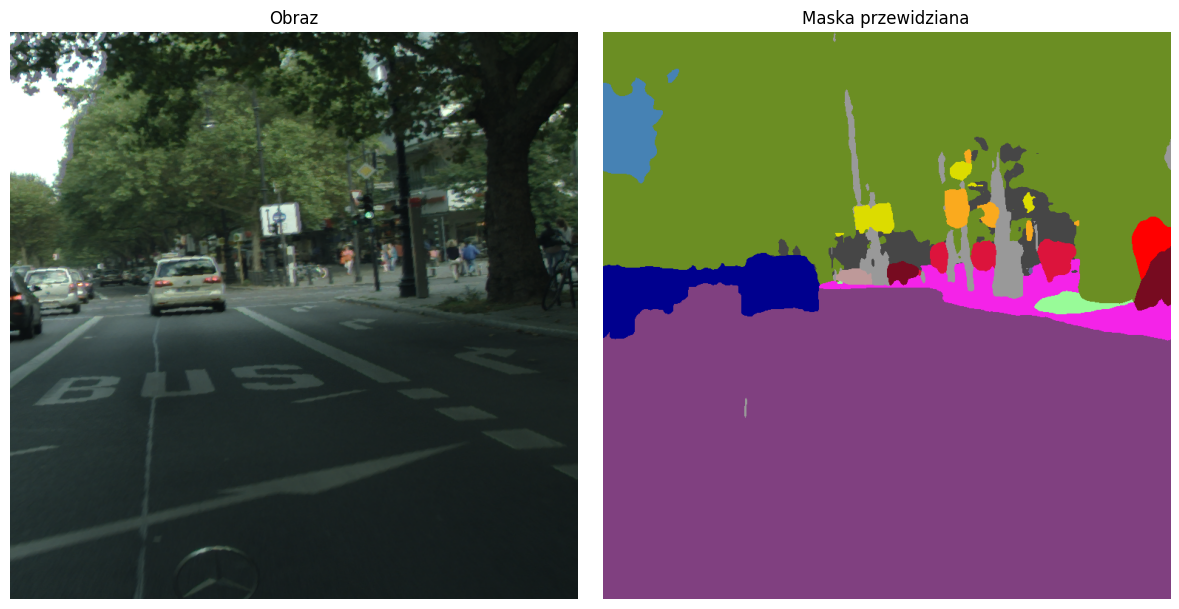

In [10]:
import torch
from torch.utils.data import DataLoader
from utils.image import *

# Custom testowy

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='test',
    target_type="semantic",
    transforms=mapper.wrap_infer
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# Inference

images, _ = next(iter(single_loader))
images = images.to(device)

with torch.inference_mode():
    logits = model(images)

pr_masks = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=images[0], 
    mask_pred=pr_masks[0], 
    mapper=mapper
)


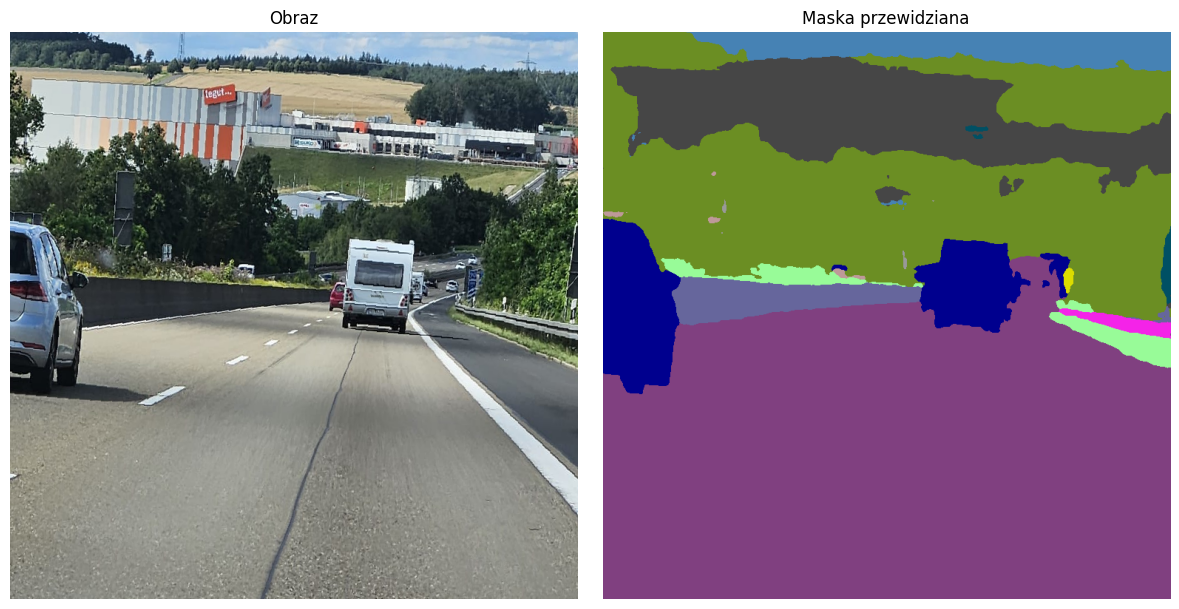

In [11]:
import torch
from PIL import Image
from utils.image import *

# Własny obraz

pil_image = Image.open(r".\test\test2.png")

aug_image = mapper.preprocess_image(img=np.asarray(pil_image))
tensor_image = aug_image.to(device)

with torch.inference_mode():
    logits = model(tensor_image)
    
pr_mask = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=tensor_image, 
    mask_pred=pr_mask, 
    mapper=mapper
)

## Benchmarkt

In [12]:
import os
from utils.benchmark import start_benchmark

logs_root = ".\\logs\\"

ckpts = find_checkpoints(logs_root)

for ckpt in ckpts.items():
    dir = os.path.dirname(
        os.path.dirname(ckpt[0])
    )
    model = ExperimentalModel.load_from_checkpoint(
        checkpoint_path=ckpt[0],
        mapper=mapper
    )
    start_benchmark(model)

Średnia latencja : 49.842 ms  |  FPS : 20.1 | Alloc: 402.0 MiB | Reserved: 1456.0 MiB | Peak: 1266.0 MiB
Średnia latencja : 59.948 ms  |  FPS : 16.7 | Alloc: 399.1 MiB | Reserved: 1448.0 MiB | Peak: 1263.1 MiB
Średnia latencja : 67.137 ms  |  FPS : 14.9 | Alloc: 408.7 MiB | Reserved: 1618.0 MiB | Peak: 1272.7 MiB
Średnia latencja : 80.018 ms  |  FPS : 12.5 | Alloc: 369.8 MiB | Reserved: 1566.0 MiB | Peak: 1026.6 MiB
Średnia latencja : 152.599 ms  |  FPS : 6.6 | Alloc: 359.7 MiB | Reserved: 6834.0 MiB | Peak: 4473.7 MiB
Średnia latencja : 129.539 ms  |  FPS : 7.7 | Alloc: 652.0 MiB | Reserved: 1708.0 MiB | Peak: 1516.0 MiB
Średnia latencja : 110.457 ms  |  FPS : 9.1 | Alloc: 369.4 MiB | Reserved: 1708.0 MiB | Peak: 1189.4 MiB
Średnia latencja : 109.751 ms  |  FPS : 9.1 | Alloc: 366.6 MiB | Reserved: 1692.0 MiB | Peak: 1186.6 MiB
